<a href="https://colab.research.google.com/github/qowngus33/captcha_recognition/blob/main/Captcha_model_parameter_setting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# gpu 사용
!nvidia-smi

Fri Nov 25 01:14:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import os
import cv2
from glob import glob
from google.colab.patches import cv2_imshow
import numpy as np

np.random.seed(42)

# 데이터를 불러오고 이미지 개수를 출력
data_list = glob('sample_data/samples/*.png')
len_data = len(data_list)
print(len(data_list))

1039


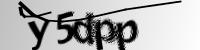

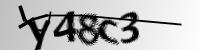

['y' '4' '8' 'c' '3']
(1039, 50, 200, 1)


In [6]:
# 샘플 이미지 출력
img = cv2.imread(data_list[0], cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)

# 이미지 크기, 채널
data_height = 50
data_width = 200
n_channel = 1

images = np.zeros((len_data, data_height, data_width, n_channel))
label = np.empty((len_data, 5), dtype = str)

characters = []

for n, path in enumerate(data_list):
  image = cv2.imread(data_list[n], cv2.IMREAD_GRAYSCALE) / 255   # 모델 학습을 위해 0 - 1 사이의 값으로 스케일링
  image = np.reshape(image, (data_height, data_width, n_channel)) 
  images[n, :, :, :] = image
  path = path.split('/')[2]
  path = path.split('.')[0]
  path = list(path)
  label[n] = np.array(path)
  for i in range(5):
    characters.append(path[i])

cv2_imshow(images[3] * 255)
print(label[3])
print(images.shape)

In [10]:
from string import ascii_lowercase, digits

# 글자 종류 확인
characters = list(set(characters))
characters.sort()
print(characters)

['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [11]:
from tensorflow import keras
import tensorflow as tf

# 라벨링
def char_to_num(num):
  if num in characters:
    return characters.index(num)
  return None
    
num_label = np.empty((5, len_data, len(characters)), dtype = int)
for i in range(len_data):
  targs = np.zeros((5, len(characters)))
  for j, l in enumerate(label[i]):
    ind = char_to_num(l)
    targs[j, ind] = 1
    num_label[:, i] = targs

y_train = keras.utils.to_categorical(y_train, num_classes)

print(num_label[3][3])

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# svc 학습
print(images[0])

In [12]:
import random
index_list = np.arange(len_data)
random.shuffle(index_list)
print(index_list)

# train, test split by index
for i in range(len_data):
  train_X, test_X = images[index_list[:900]], images[index_list[900:]]
  train_y, test_y = num_label[:,index_list[:900]], num_label[:,index_list[900:]]

print(len(train_X),len(test_X))
print(train_X.shape)
print(len(train_y[0]),len(test_y[0]))
print(train_y[3])

[  69  301  248 ... 1037  180  877]
900 139
(900, 50, 200, 1)
900 139
[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]


In [50]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras import layers

In [51]:
def create_model(num_classes):
    img = layers.Input(shape=(50, 200, 1)) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="valid")(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="valid")(bn)  # 25x7
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_classes, activation='sigmoid')(drop)
        outs.append(res)
    
    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [52]:
num_classes = len(characters)
model = create_model(num_classes)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 50, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 50, 200, 16)  160         ['input_5[0][0]']                
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 25, 100, 16)  0          ['conv2d_12[0][0]']              
 )                                                                                                
                                                                                            

In [53]:
# model.fit(train_X, [train_y[0],train_y[1],train_y[2],train_y[3],train_y[4]], epochs=10, batch_size=200, verbose=2,validation_split=0.2)
hist = model.fit(train_X, [train_y[0], train_y[1], train_y[2], train_y[3], train_y[4]], batch_size=32, epochs=100,verbose=1, validation_split=0.2)

Epoch 1/100
23/23 [==============================] - 2s 38ms/step - loss: 15.2885 - dense_41_loss: 3.0890 - dense_43_loss: 3.0616 - dense_45_loss: 3.0198 - dense_47_loss: 3.0760 - dense_49_loss: 3.0420 - dense_41_accuracy: 0.0403 - dense_43_accuracy: 0.0931 - dense_45_accuracy: 0.0806 - dense_47_accuracy: 0.0639 - dense_49_accuracy: 0.0611 - val_loss: 14.7117 - val_dense_41_loss: 2.9424 - val_dense_43_loss: 2.9416 - val_dense_45_loss: 2.9435 - val_dense_47_loss: 2.9436 - val_dense_49_loss: 2.9406 - val_dense_41_accuracy: 0.0278 - val_dense_43_accuracy: 0.0611 - val_dense_45_accuracy: 0.1167 - val_dense_47_accuracy: 0.1000 - val_dense_49_accuracy: 0.0500
Epoch 2/100
23/23 [==============================] - 0s 14ms/step - loss: 14.6113 - dense_41_loss: 2.9226 - dense_43_loss: 2.8890 - dense_45_loss: 2.9317 - dense_47_loss: 2.9370 - dense_49_loss: 2.9311 - dense_41_accuracy: 0.0528 - dense_43_accuracy: 0.0958 - dense_45_accuracy: 0.1042 - dense_47_accuracy: 0.0889 - dense_49_accuracy: 0.1

In [54]:
def predict_x(img):
    img = np.reshape(img, (1, 50, 200, 1))
    res = np.array(model.predict(img))
    ans = np.reshape(res, (5, num_classes))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += characters[l]
    return capt#, sum(probs) / 5

In [55]:
def print_y(y_list):
  result = ""
  for y in y_list:
    for i in range(len(y)):
      if int(y[i]) == 1:
        result += characters[i]
  return result

In [56]:
print(predict_x(test_X[0]))
print(print_y([test_y[0][0], test_y[1][0], test_y[2][0], test_y[3][0], test_y[4][0]]))

1/1 [==============================] - 0s 125ms/step
3ye2e
3ye2e


In [57]:
count = 0
for i in range(len(train_X)):
  if predict_x(train_X[i]) != print_y([train_y[0][i], train_y[1][i], train_y[2][i], train_y[3][i], train_y[4][i]]):
    count += 1

print((len(train_X)-count)/len(train_X))
print(len(train_X))

1/1 [==============================] - 0s 14ms/step
0.8644444444444445
900


In [58]:
from sklearn import metrics
import matplotlib.pyplot as plt
count = 0
y_pred = []
y_true = []
index = []

for i in range(len(train_X)):
  predictresult = predict_x(train_X[i])
  realresult = print_y([train_y[0][i], train_y[1][i], train_y[2][i], train_y[3][i], train_y[4][i]])
  for j in range(len(predictresult)):
    y_pred.append(predictresult[j])
    y_true.append(realresult[j]) 
    if (predictresult[j] == "b") and (realresult[j] == "p"):
      index.append(i)

print("p를 b로 misclassification: " + str(len(index)))

1/1 [==============================] - 0s 20ms/step
p를 b로 misclassification: 0


0.9655555555555555
0.9649374378644386
0.969694991311111
0.9649374378644386
0.9666174690821214
(19, 19)


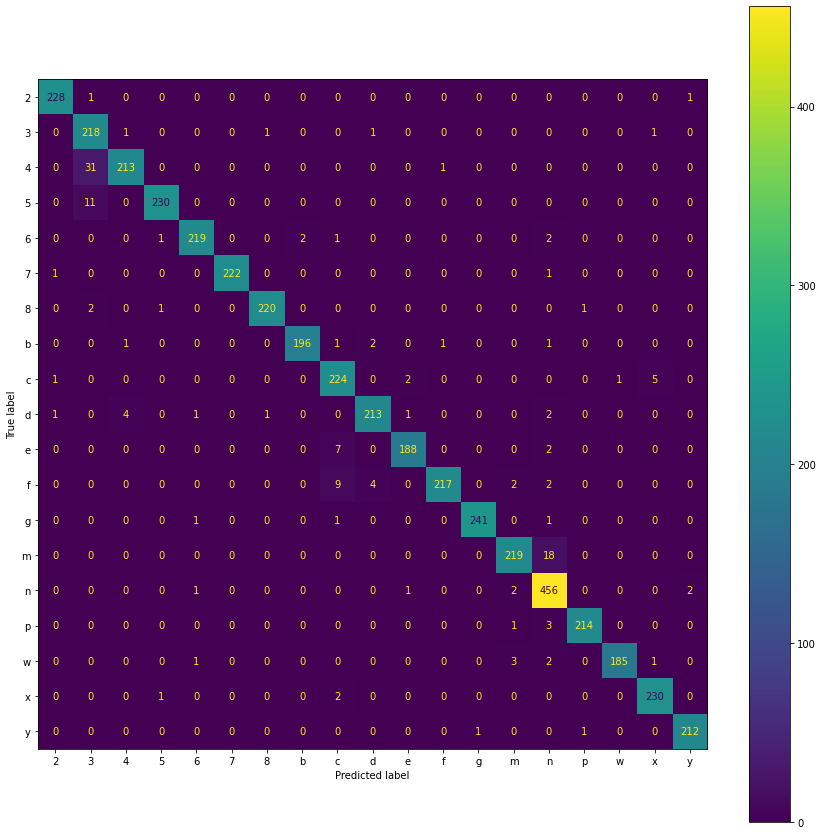

In [59]:
print(metrics.accuracy_score(y_true, y_pred)) 
print(metrics.balanced_accuracy_score(y_true, y_pred)) 
print(metrics.precision_score(y_true, y_pred,average="macro"))
print(metrics.recall_score(y_true, y_pred,average="macro"))
print(metrics.f1_score(y_true, y_pred,average="macro")) 

conf_mat = metrics.confusion_matrix(y_true, y_pred) 
print(conf_mat.shape)
conf_dis = metrics.ConfusionMatrixDisplay(conf_mat, display_labels=characters)
fig, ax = plt.subplots(figsize=(15, 15))
conf_dis.plot(ax = ax)

In [60]:
# p를 b로 misclassification한 경우
for i in range(len(index)):
  cv2_imshow(train_X[index[i]] * 255)